In [41]:
import pandas as pd
import numpy as np
import nltk
import re
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from transformers import BertTokenizer

/Users/AH00434/opt/anaconda3/envs/nlp_venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Data Load

In [106]:
train_df = pd.read_csv('../data/stsb-en-train.csv', usecols=[0,1,2], names=['sent1', 'sent2', 'score'], header=None)

In [107]:
train_df.head()

,sent1,sent2,score
0,A plane is taking off.,An air plane is taking off.,5.00
1,A man is playing a large flute.,A man is playing a flute.,3.80
2,A man is spreading shreded cheese on a pizza.,A man is spreading shredded cheese on an uncoo...,3.80
3,Three men are playing chess.,Two men are playing chess.,2.60
4,A man is playing the cello.,A man seated is playing the cello.,4.25


In [108]:
val_df = pd.read_csv('../data/stsb-en-dev.csv', usecols=[0,1,2], names=['sent1', 'sent2', 'score'], header=None)

In [109]:
val_df.head()

,sent1,sent2,score
0,A man with a hard hat is dancing.,A man wearing a hard hat is dancing.,5.00
1,A young child is riding a horse.,A child is riding a horse.,4.75
2,A man is feeding a mouse to a snake.,The man is feeding a mouse to the snake.,5.00
3,A woman is playing the guitar.,A man is playing guitar.,2.40
4,A woman is playing the flute.,A man is playing a flute.,2.75


In [110]:
test_df = pd.read_csv('../data/stsb-en-test.csv', usecols=[0,1,2], names=['sent1', 'sent2', 'score'], header=None)

In [111]:
test_df.head()

,sent1,sent2,score
0,A girl is styling her hair.,A girl is brushing her hair.,2.5
1,A group of men play soccer on the beach.,A group of boys are playing soccer on the beach.,3.6
2,One woman is measuring another woman's ankle.,A woman measures another woman's ankle.,5.0
3,A man is cutting up a cucumber.,A man is slicing a cucumber.,4.2
4,A man is playing a harp.,A man is playing a keyboard.,1.5


In [112]:
#Statistics
print("Train data size", len(train_df))
print("Val data size", len(val_df))
print("Test data size", len(test_df))

Train data size 5749
Val data size 1500
Test data size 1379


# Data Cleaning

In [113]:
from nltk.corpus import stopwords

In [115]:
#nltk.download('wordnet')

In [117]:
#nltk.download('stopwords')

In [118]:
stop_words = set(stopwords.words('english'))

In [119]:
lemmatizer = WordNetLemmatizer()
ps = PorterStemmer()

In [120]:
def replace_url(text):
    return re.sub(r'(http|ftp|https)://([\w_-]+(?:(?:\.[\w_-]+)+))([\w.,@?^=%&:/~+#-]*[\w@?^=%&/~+#-])?', 'url', text)


def replace_hashtags(text):
    return re.sub(r'#[a-zA-Z\d]+',  'hashtag', text)


def replace_email(text):
    return re.sub(r'[a-zA-Z\.]+@[a-zA-Z\.\d]+',  'email', text)


def replace_mentions(text):
    return re.sub(r'@[a-zA-Z\.\d_]+',  'mention', text)


def remove_abbrevations(text):
    text = re.sub(r"he's", "he is", text)
    text = re.sub(r"there's", "there is", text)
    text = re.sub(r"We're", "We are", text)
    text = re.sub(r"That's", "That is", text)
    text = re.sub(r"won't", "will not", text)
    text = re.sub(r"they're", "they are", text)
    text = re.sub(r"Can't", "Cannot", text)
    text = re.sub(r"wasn't", "was not", text)
    text = re.sub(r"don\x89Ûªt", "do not", text)
    text = re.sub(r"aren't", "are not", text)
    text = re.sub(r"isn't", "is not", text)
    text = re.sub(r"What's", "What is", text)
    text = re.sub(r"haven't", "have not", text)
    text = re.sub(r"hasn't", "has not", text)
    text = re.sub(r"There's", "There is", text)
    text = re.sub(r"He's", "He is", text)
    text = re.sub(r"It's", "It is", text)
    text = re.sub(r"You're", "You are", text)
    text = re.sub(r"I'M", "I am", text)
    text = re.sub(r"shouldn't", "should not", text)
    text = re.sub(r"wouldn't", "would not", text)
    text = re.sub(r"i'm", "I am", text)
    text = re.sub(r"I\x89Ûªm", "I am", text)
    text = re.sub(r"I'm", "I am", text)
    text = re.sub(r"Isn't", "is not", text)
    text = re.sub(r"Here's", "Here is", text)
    text = re.sub(r"you've", "you have", text)
    text = re.sub(r"you\x89Ûªve", "you have", text)
    text = re.sub(r"we're", "we are", text)
    text = re.sub(r"what's", "what is", text)
    text = re.sub(r"couldn't", "could not", text)
    text = re.sub(r"we've", "we have", text)
    text = re.sub(r"it\x89Ûªs", "it is", text)
    text = re.sub(r"doesn\x89Ûªt", "does not", text)
    text = re.sub(r"It\x89Ûªs", "It is", text)
    text = re.sub(r"Here\x89Ûªs", "Here is", text)
    text = re.sub(r"who's", "who is", text)
    text = re.sub(r"I\x89Ûªve", "I have", text)
    text = re.sub(r"y'all", "you all", text)
    text = re.sub(r"can\x89Ûªt", "cannot", text)
    text = re.sub(r"would've", "would have", text)
    text = re.sub(r"it'll", "it will", text)
    text = re.sub(r"we'll", "we will", text)
    text = re.sub(r"wouldn\x89Ûªt", "would not", text)
    text = re.sub(r"We've", "We have", text)
    text = re.sub(r"he'll", "he will", text)
    text = re.sub(r"Y'all", "You all", text)
    text = re.sub(r"Weren't", "Were not", text)
    text = re.sub(r"Didn't", "Did not", text)
    text = re.sub(r"they'll", "they will", text)
    text = re.sub(r"they'd", "they would", text)
    text = re.sub(r"DON'T", "DO NOT", text)
    text = re.sub(r"That\x89Ûªs", "That is", text)
    text = re.sub(r"they've", "they have", text)
    text = re.sub(r"i'd", "I would", text)
    text = re.sub(r"should've", "should have", text)
    text = re.sub(r"You\x89Ûªre", "You are", text)
    text = re.sub(r"where's", "where is", text)
    text = re.sub(r"Don\x89Ûªt", "Do not", text)
    text = re.sub(r"we'd", "we would", text)
    text = re.sub(r"i'll", "I will", text)
    text = re.sub(r"weren't", "were not", text)
    text = re.sub(r"They're", "They are", text)
    text = re.sub(r"Can\x89Ûªt", "Cannot", text)
    text = re.sub(r"you\x89Ûªll", "you will", text)
    text = re.sub(r"I\x89Ûªd", "I would", text)
    text = re.sub(r"let's", "let us", text)
    text = re.sub(r"it's", "it is", text)
    text = re.sub(r"can't", "cannot", text)
    text = re.sub(r"don't", "do not", text)
    text = re.sub(r"you're", "you are", text)
    text = re.sub(r"i've", "I have", text)
    text = re.sub(r"that's", "that is", text)
    text = re.sub(r"i'll", "I will", text)
    text = re.sub(r"doesn't", "does not", text)
    text = re.sub(r"i'd", "I would", text)
    text = re.sub(r"didn't", "did not", text)
    text = re.sub(r"ain't", "am not", text)
    text = re.sub(r"you'll", "you will", text)
    text = re.sub(r"I've", "I have", text)
    text = re.sub(r"Don't", "do not", text)
    text = re.sub(r"I'll", "I will", text)
    text = re.sub(r"I'd", "I would", text)
    text = re.sub(r"Let's", "Let us", text)
    text = re.sub(r"you'd", "You would", text)
    text = re.sub(r"It's", "It is", text)
    text = re.sub(r"Ain't", "am not", text)
    text = re.sub(r"Haven't", "Have not", text)
    text = re.sub(r"Could've", "Could have", text)
    text = re.sub(r"youve", "you have", text)
    text = re.sub(r"donå«t", "do not", text)
    text = re.sub(r"shan't", "shall not", text)
    text = re.sub(r"'Tis", "it is", text)
    text = re.sub(r"what's", "what is", text)
    return text


In [50]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [128]:
def preprocess_text_bert(text):
    # Remove punctuation
    text = re.sub(r'[^\w\s]', '', text)
    # Replace numbers with num
    text = re.sub(r'\d+', 'num', text)
    #preprocessings
    text = replace_url(text)
    text = replace_hashtags(text)
    text = replace_email(text)
    text = replace_mentions(text)
    text = remove_abbrevations(text)
    # Lower case
    text= text.lower()
    #sent_token = text.split()
    #sent_token = tokenizer.tokenize(text)
    #stop words removal
    #sent_token = [word for word in sent_token if word.lower() not in stop_words]
    # Lemmatize
    #sent_token = [lemmatizer.lemmatize(word) for word in sent_token]
    # Stemming
    #sent_token = [ps.stem(word) for word in sent_token]
    return text

In [67]:
def preprocess_text_nltk(text):
    # Remove punctuation
    text = re.sub(r'[^\w\s]', '', text)
    # Replace numbers with num
    text = re.sub(r'\d+', 'num', text)
    #preprocessings
    text = replace_url(text)
    text = replace_hashtags(text)
    text = replace_email(text)
    text = replace_mentions(text)
    text = remove_abbrevations(text)
    # Lower case
    text= text.lower()
    sent_token = text.split()
    #stop words removal
    sent_token = [word for word in sent_token if word.lower() not in stop_words]
    # Lemmatize
    sent_token = [lemmatizer.lemmatize(word) for word in sent_token]
    # Stemming
    #sent_token = [ps.stem(word) for word in sent_token]
    return sent_token

In [124]:
train_df['sent1'] =train_df['sent1'].apply(lambda x: preprocess_text_bert(x))
train_df['sent2'] =train_df['sent2'].apply(lambda x: preprocess_text_bert(x))

In [125]:
val_df['sent1'] =val_df['sent1'].apply(lambda x: preprocess_text_bert(x))
val_df['sent2'] =val_df['sent2'].apply(lambda x: preprocess_text_bert(x))

In [126]:
test_df['sent1'] =test_df['sent1'].apply(lambda x: preprocess_text_bert(x))
test_df['sent2'] =test_df['sent2'].apply(lambda x: preprocess_text_bert(x))

In [80]:
total_sents = list(train_df['sent1'])

In [81]:
total_sents.extend(list(train_df['sent2']))

In [82]:
len(total_sents)/2

5749.0

In [83]:
total_sents[0:5]

[['a', 'plane', 'is', 'taking', 'off'],
 ['a', 'man', 'is', 'playing', 'a', 'large', 'flute'],
 ['a',
  'man',
  'is',
  'spreading',
  'sh',
  '##red',
  '##ed',
  'cheese',
  'on',
  'a',
  'pizza'],
 ['three', 'men', 'are', 'playing', 'chess'],
 ['a', 'man', 'is', 'playing', 'the', 'cello']]

In [59]:
lemmatizer.lemmatize("played")

'played'

In [84]:
word_dict = {}
for word_tokens in total_sents:
    for word in word_tokens:
        if word in word_dict:
            word_dict[word] += 1
        else:
            word_dict[word] = 1

In [85]:
vocab_length = len(word_dict)

In [86]:
vocab_length

10618

In [87]:
uni_count = 0
for value in word_dict.values():
    if value == 1:
        uni_count += 1
print(uni_count)

2729


In [88]:
def get_sorted_counter(word_counter):
    return {k: v for k, v in sorted(word_counter.items(), key=lambda item: item[1], reverse=False)}

In [89]:
sorted_counter = get_sorted_counter(word_dict)

In [90]:
sorted_counter

{'cub': 1,
 'yoga': 1,
 'levi': 1,
 '##tat': 1,
 'richie': 1,
 'checking': 1,
 'cale': 1,
 'kang': 1,
 'motorized': 1,
 '##ool': 1,
 'packing': 1,
 'oven': 1,
 '##uta': 1,
 'knocks': 1,
 '##tila': 1,
 'cooked': 1,
 'boards': 1,
 'patio': 1,
 'vodka': 1,
 '##ein': 1,
 'crushing': 1,
 'fingernails': 1,
 'emery': 1,
 'shower': 1,
 'chi': 1,
 'sprayed': 1,
 '##lip': 1,
 'splits': 1,
 'mixes': 1,
 '##cycle': 1,
 'jug': 1,
 'soda': 1,
 'ra': 1,
 'garland': 1,
 'sing': 1,
 'barked': 1,
 '##grapher': 1,
 'paste': 1,
 'soup': 1,
 'followed': 1,
 'creature': 1,
 'sumo': 1,
 'lays': 1,
 'grazed': 1,
 'swat': 1,
 'patting': 1,
 'alligator': 1,
 'salt': 1,
 'stared': 1,
 'happily': 1,
 'bon': 1,
 'rabbits': 1,
 'chewed': 1,
 'submarine': 1,
 'crying': 1,
 'marching': 1,
 '##icum': 1,
 'pianos': 1,
 'praying': 1,
 'styling': 1,
 'herbs': 1,
 'dangling': 1,
 '##pipe': 1,
 'gorilla': 1,
 'curb': 1,
 'squash': 1,
 '##lance': 1,
 'ballet': 1,
 'slabs': 1,
 'toss': 1,
 'towels': 1,
 'scraping': 1,
 'wavi

In [91]:
sent_dict = {}
for sent in total_sents:
    if len(sent) in sent_dict:
        sent_dict[len(sent)] += 1
    else:
        sent_dict[len(sent)] = 1

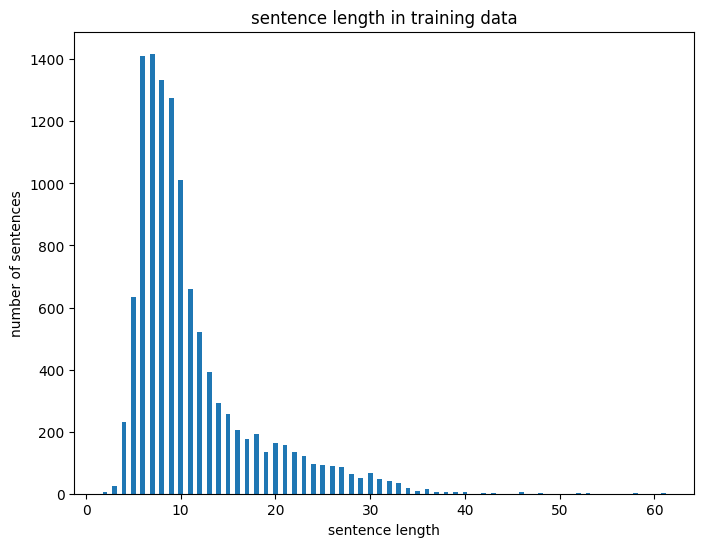

In [92]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(8, 6))
ax.bar(list(sent_dict.keys()), list(sent_dict.values()), width=0.5)
plt.title("sentence length in training data")
plt.xlabel("sentence length")
plt.ylabel("number of sentences")
plt.show()

In [33]:
# def unk_replace(word, word_dict):
#     if word not in word_dict:
#         return "unk"
#     else:
#         if word_dict[word] < 2:
#             return "unk"
#     return word

In [34]:
# train_df['sent1'] = train_df['sent1'].apply(lambda x: [unk_replace(word, word_dict) for word in x])
# train_df['sent2'] = train_df['sent2'].apply(lambda x: [unk_replace(word, word_dict) for word in x])

In [35]:
# val_df['sent1'] = val_df['sent1'].apply(lambda x: [unk_replace(word, word_dict) for word in x])
# val_df['sent2'] = val_df['sent2'].apply(lambda x: [unk_replace(word, word_dict) for word in x])

In [36]:
# test_df['sent1'] = test_df['sent1'].apply(lambda x: [unk_replace(word, word_dict) for word in x])
# test_df['sent2'] = test_df['sent2'].apply(lambda x: [unk_replace(word, word_dict) for word in x])

In [93]:
total_sents_unk = list(val_df['sent1'])

In [94]:
total_sents_unk.extend(list(val_df['sent2']))

In [95]:
sent_dict = {}
for sent in total_sents_unk:
    if len(sent) in sent_dict:
        sent_dict[len(sent)] += 1
    else:
        sent_dict[len(sent)] = 1

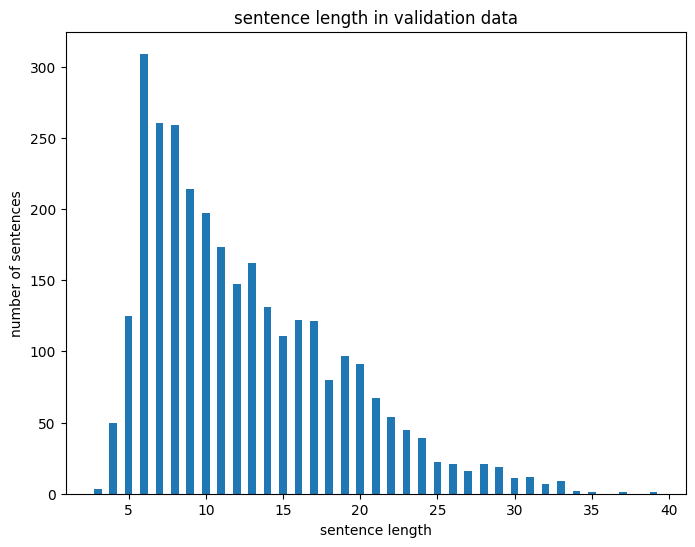

In [96]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.bar(list(sent_dict.keys()), list(sent_dict.values()), width=0.5)
plt.title("sentence length in validation data")
plt.xlabel("sentence length")
plt.ylabel("number of sentences")
plt.show()

In [97]:
test_sents_unk = list(test_df['sent1'])
test_sents_unk.extend(list(test_df['sent2']))

In [98]:
sent_dict = {}
for sent in test_sents_unk:
    if len(sent) in sent_dict:
        sent_dict[len(sent)] += 1
    else:
        sent_dict[len(sent)] = 1

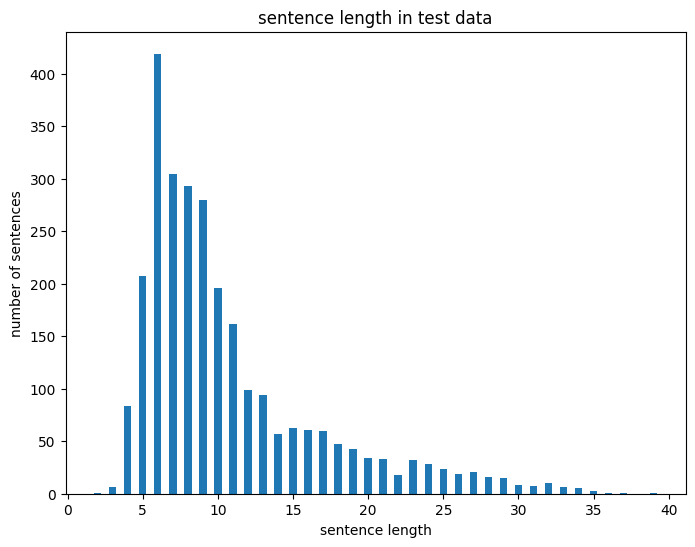

In [99]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.bar(list(sent_dict.keys()), list(sent_dict.values()), width=0.5)
plt.title("sentence length in test data")
plt.xlabel("sentence length")
plt.ylabel("number of sentences")
plt.show()

window size of 30 or less than 30 should be good as test data maximum length of a sentence is less than 30

In [127]:
train_df.to_csv("../data/cleaned_train_df_sent.csv", index=False)  
val_df.to_csv("../data/cleaned_val_df_sent.csv", index=False)  
test_df.to_csv("../data/cleaned_test_df_sent.csv", index=False)  

In [101]:
import pickle
with open('../data/word_dict_v2.pickle', 'wb') as handle:
    pickle.dump(word_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [102]:
len(word_dict)

10618

In [104]:
pwd

'/Users/AH00434/PycharmProjects/semantic_similarity/experiments'